# Capacity allocation

## 0. Load libraries

In [ ]:
%load_ext autoreload
%autoreload 2

import datetime
import itertools
import numpy as np
import pyomo.environ as pyo
import shutil

from benchmarks.generator import get_revenue_behavior_deprecated
from benchmarks.utils import int_input, get_schedule_from_supply, infer_line_stations, \
    get_services_by_tsp_df, plot_marey_chart, SAFETY_GAP
from src.entities import Solution
from src.timetabling_problem import MPTT

from math import e, pi
from pathlib import Path
from robin.services_generator.entities import ServiceGenerator
from robin.supply.entities import Supply
from robin.supply.generator.entities import ServiceScheduler
from robin.supply.saver.entities import SupplySaver

In [2]:
# Config files
supply_config_path = Path('../configs/generator/supply_config.yml')
demand_config_path = Path('../configs/demand/demand.yml')
generator_config_path = Path('../configs/generator/generator_config.yml')

# Save paths
generator_save_path = Path(f'../data/generator/supply_dummy.yml')
supply_save_path = '../configs/mealpy/'
robin_save_path = '../data/output/robin/'
figures = '../figures/'

# Clean save paths directories
if Path(generator_save_path.parent).exists():
    shutil.rmtree(generator_save_path.parent)

Path(generator_save_path.parent).mkdir(parents=True)

if Path(supply_save_path).exists():
    shutil.rmtree(supply_save_path)
    
Path(supply_save_path).mkdir(parents=True)

#if Path(figures).exists():
#    shutil.rmtree(figures)
#Path(figures).mkdir(parents=True)

In [3]:
seed = 21

if generator_config_path:
    n_services = int_input('Number of services to generate: ')
    generator = ServiceGenerator(supply_config_path=supply_config_path)
    _ = generator.generate(output_path=generator_save_path,
                           path_config=generator_config_path,
                           n_services=n_services,
                           seed=seed)
    print(f'Number of service requests generated: {len(_)}')

Number of service requests generated: 25


In [7]:
generator_save_path = '../data/generator/supply_conflicts.yml'

In [8]:
supply = Supply.from_yaml(generator_save_path)
tsp_df = get_services_by_tsp_df(supply.services)

print(tsp_df)

     Number of Services
RU1                   1
RU4                   1
RU5                   1


In [9]:
print('Services: ', len(supply.services))
requested_schedule = get_schedule_from_supply(generator_save_path)
revenue_behavior = get_revenue_behavior_deprecated(supply)
lines = list(supply.lines)
line = infer_line_stations(lines)

Services:  3


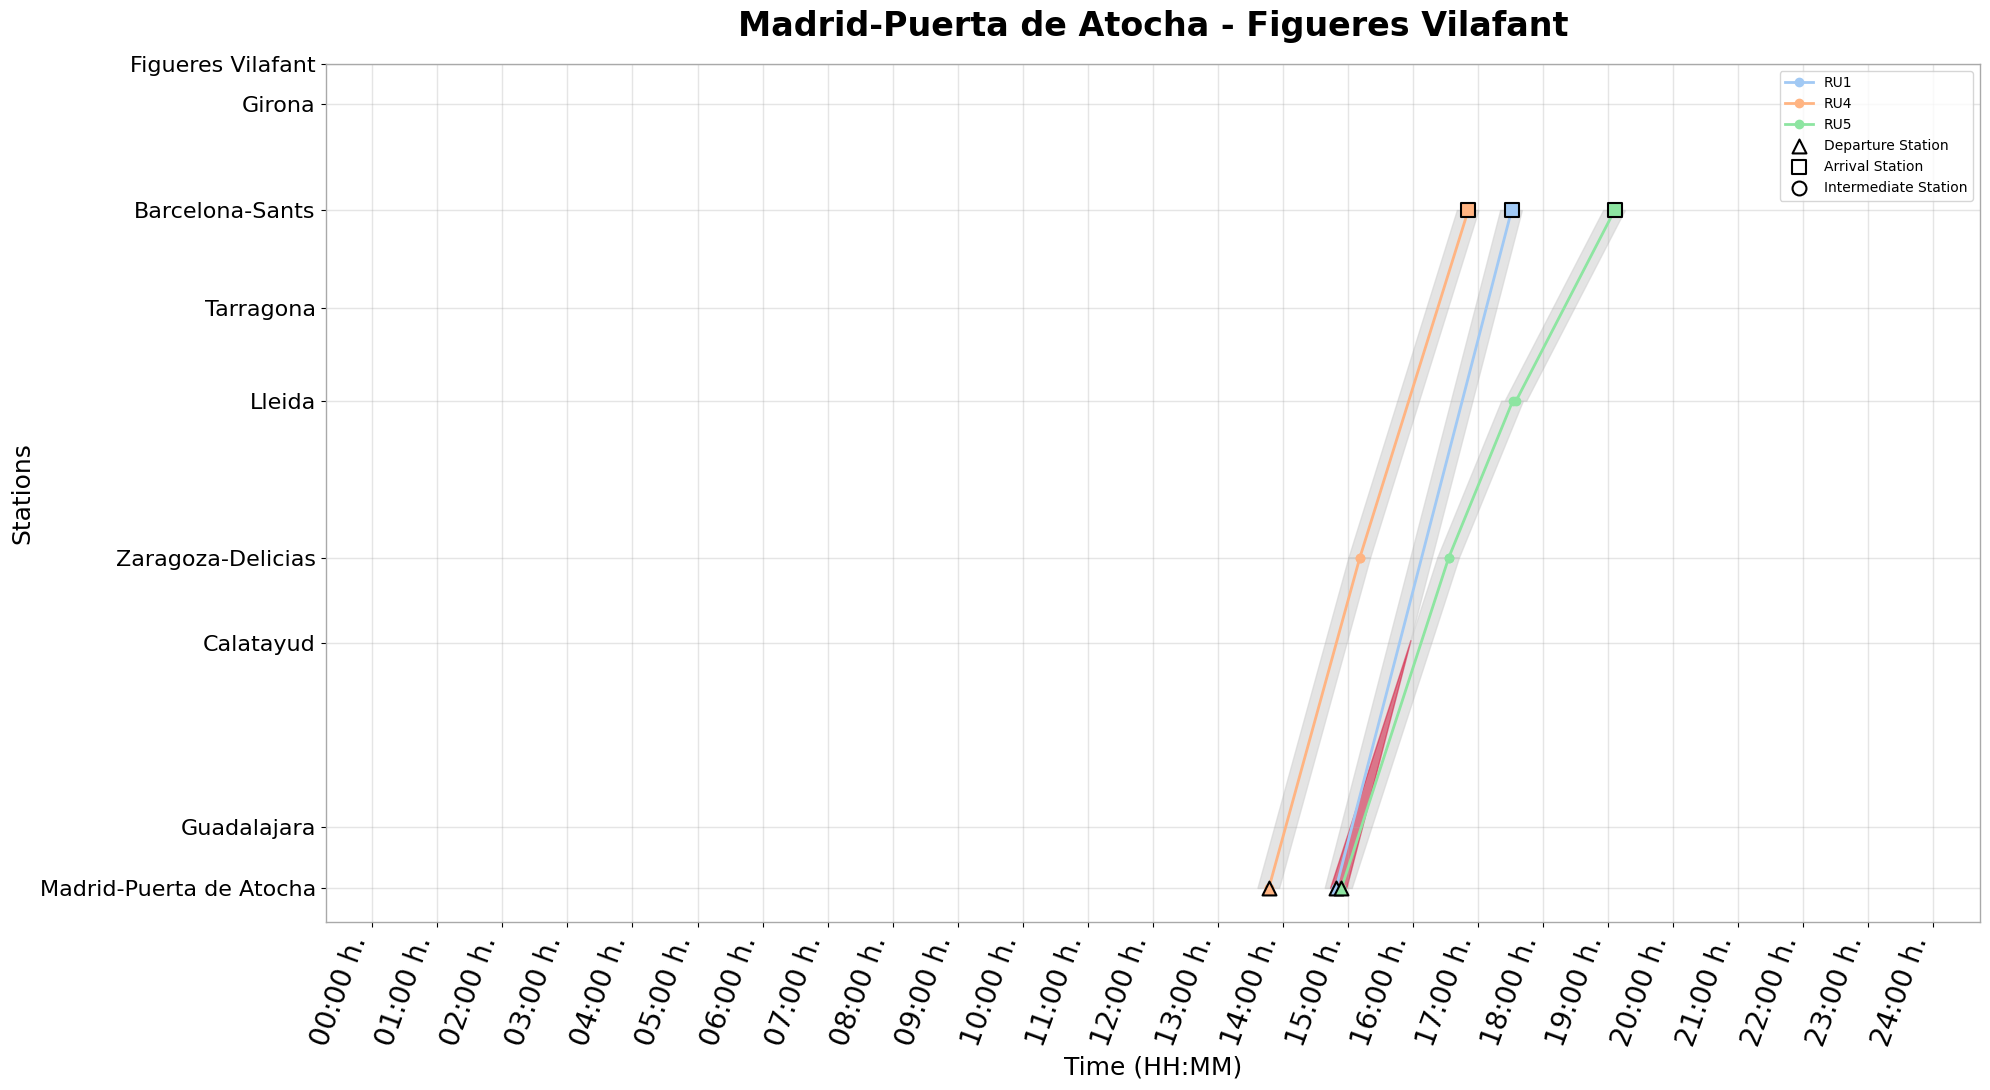

In [10]:
date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()
plot_marey_chart(
    supply=supply,
    date=date,
    save_path='../figures/escim2025/'
)

## 1. Pyomo

In [11]:
mptt = MPTT(
    requested_schedule=requested_schedule,
    revenue_behavior=revenue_behavior,
    line=line,
    safe_headway=SAFETY_GAP
)

In [12]:
departure_times = {}
travel_times = {}
dwell_times = {}
lower_bounds = {}
upper_bounds = {}
for service in supply.services:
    for i, (station, (arrival, departure)) in enumerate(service.schedule.items()):
        if len(service.schedule) > 1 and i == len(service.schedule) - 1:
            break
        service_stations_dict = {station.id: station for station in service.line.stations}
        station = service_stations_dict[station]
        departure_times[(service.id, station.id)] = departure.total_seconds() // 60
        travel_times[(service.id, station.id)] = (tuple(service.schedule.values())[i+1][0] - departure).total_seconds() / 60
        dwell_times[(service.id, station.id)] = (departure - arrival).total_seconds() / 60
        # Equation 2
        lower_bounds[(service.id, station.id)] = departure.total_seconds() // 60 - 60
        upper_bounds[(service.id, station.id)] = departure.total_seconds() // 60 + 60

In [13]:
def bounds_schedule_times(model, service, station):
    return (lower_bounds[(service, station)], upper_bounds[(service, station)])

In [14]:
scheduler = ServiceScheduler(supply.services)

In [15]:
services_segments = list(scheduler.segments.values())

segments = [segment for service_segments in services_segments for segment in service_segments]
print(f'Segments: {len(segments)}')

segments_combinations = [((segment1.service_id, segment1), (segment2.service_id, segment2)) for segment1, segment2 in itertools.product(segments, segments)]
segments_combinations = list(filter(lambda x: x[0][0] != x[1][0], segments_combinations))
print(f'Segments combinations: {len(segments_combinations)}')

filtered_segments_combinations = []
for (service1, segment1), (service2, segment2) in segments_combinations:
    common_edges = set(segment1.edges) & set(segment2.edges)
    if common_edges:
        filtered_segments_combinations.append(((service1, segment1), (service2, segment2)))
print(f'Filtered segments combinations: {len(filtered_segments_combinations)}')

common_edges = {}
for (service1, segment1), (service2, segment2) in filtered_segments_combinations:
    common_edges[(service1, segment1, service2, segment2)] = set(segment1.edges) & set(segment2.edges)
print(f'Common edges: {len(common_edges)}')


Segments: 6
Segments combinations: 22
Filtered segments combinations: 16
Common edges: 16


In [16]:
IM_BOUND = 60
MAX_DWELL_TIME = 10

services = {service.id: service for service in supply.services}

model = pyo.ConcreteModel()

service_station_idx = list(travel_times.keys())
services_names = list(dict.fromkeys(mptt.service_indexer))

model.requests = pyo.Set(initialize=service_station_idx, dimen=2)
model.segments = pyo.Set(initialize=filtered_segments_combinations, dimen=4)

model.schedule_times = pyo.Var(model.requests, within=pyo.NonNegativeReals, bounds=bounds_schedule_times)
model.is_scheduled = pyo.Var(services_names, within=pyo.Binary)

model.departure_times = pyo.Param(model.requests, initialize=departure_times, within=pyo.NonNegativeReals)
model.travel_times = pyo.Param(model.requests, initialize=travel_times, within=pyo.NonNegativeReals)
model.dwell_times = pyo.Param(model.requests, initialize=dwell_times, within=pyo.NonNegativeReals)
model.common_edges = pyo.Param(model.segments, initialize=common_edges, within=pyo.Any)


def penalty_function(x: float, k: float) -> float:
    """
    Calculate the penalty function based on the given parameters.

    Args:
        x (float): Normalized deviation from the ideal schedule time.
        k (float): Penalty factor that influences the steepness of the penalty curve.

    Returns:
        float: The penalty value calculated using the formula.
    """
    return 1 - e ** (-k * x ** 2) * (0.5 * pyo.cos(pi * x) + 0.5)


def departure_time_penalty(model: pyo.ConcreteModel, service: str, im_bound: int = IM_BOUND) -> float:
    """
    Calculate the penalty for the departure time of a service.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times.
        service (str): Service ID for which the penalty is calculated.
        im_bound (int): Maximum allowed deviation in minutes (default is 60).

    Returns:
        float: Penalty value based on the departure time deviation.
    """
    first_station_id = services[service].line.stations[0].id
    alpha = penalty_function(
        x = abs(model.schedule_times[(service, first_station_id)] - list(mptt.requested_schedule[service].values())[0][1]) / im_bound,
        k = revenue_behavior[service]['k']
    )
    return alpha * revenue_behavior[service]['dt_max_penalty']

def travel_time_penalty(model: pyo.ConcreteModel, service: str, im_bound: int = IM_BOUND) -> float:
    """
    Calculate the penalty for the travel time of a service.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times.
        service (str): Service ID for which the penalty is calculated.
        im_bound (int): Maximum allowed deviation in minutes (default is 60).

    Returns:
        float: Penalty value based on the travel time deviation.
    """
    total_travel_time_penalty = 0.0
    for j in range(len(mptt.requested_schedule[service]) - 2):
        next_station_id = list(mptt.requested_schedule[service].keys())[j + 1]
        station_id = list(mptt.requested_schedule[service].keys())[j]
        updated_travel_time = model.schedule_times[(service, next_station_id)] - model.schedule_times[(service, station_id)] - model.dwell_times[(service, station_id)]
        beta = penalty_function(
            x=abs(updated_travel_time - model.travel_times[(service, station_id)]) / im_bound,
            k=revenue_behavior[service]['k']
        )
        total_travel_time_penalty += beta * revenue_behavior[service]['tt_max_penalty']
    return total_travel_time_penalty

# Equation 1
@model.Objective(sense=pyo.maximize)
def objective_function(model: pyo.ConcreteModel):
    """
    Objective function to maximize the total revenue from scheduled services.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the scheduled services and their penalties.

    Returns:
        float: Total revenue adjusted by penalties for each scheduled service.
    """
    return sum(
        model.is_scheduled[service_id] * (revenue_behavior[service_id]['canon'] - departure_time_penalty(model, service_id) - travel_time_penalty(model, service_id))
        for service_id in services_names
    )

# Equation 3
def departure_time_rule(model: pyo.ConcreteModel, service: str, station_id: str) -> bool:
    """
    Check the departure time of a service in next station is after the previous station's departure time plus travel and dwell times.
    Returns True if the condition is met, False otherwise.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times and travel/dwell times.
        service (str): Service ID for which the constraint is applied.
        j (int): Index of the station in the service schedule.

    Returns:
        pyo.Constraint: Constraint ensuring the departure time condition is met.
    """
    first_station_id = list(mptt.requested_schedule[service].keys())[0]
    if station_id == first_station_id:
        return pyo.Constraint.Skip
    station_id_idx = list(mptt.requested_schedule[service].keys()).index(station_id)
    previous_station_id = list(mptt.requested_schedule[service].keys())[station_id_idx - 1]
    return (
        model.schedule_times[(service, station_id)] * model.is_scheduled[service]
        >= (model.schedule_times[(service, previous_station_id)]
           + model.travel_times[(service, previous_station_id)]
           + model.dwell_times[(service, station_id)]) * model.is_scheduled[service]
    )

model.departure_time_restriction = pyo.Constraint(model.requests, rule=departure_time_rule)

# Equation 4
def dwell_time_arrival_rule(model, service, station_id, max_dwell_time=MAX_DWELL_TIME) -> bool:
    """
    Ensure that the schedule time at the arrival station is less than or equal to the departure time plus maximum dwell time.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times and is_scheduled variables.
        service (str): Service ID for which the constraint is applied.
        j (int): Index of the station in the service schedule.
        max_dwell_time (int): Maximum allowed dwell time in minutes (default is 10).

    Returns:
        bool: Constraint ensuring the schedule time at the arrival station is within the allowed limits.
    """
    first_station_id = list(mptt.requested_schedule[service].keys())[0]
    if station_id == first_station_id:
        return pyo.Constraint.Skip
    return (
        model.schedule_times[(service, station_id)] * model.is_scheduled[service]
        <= (model.departure_times[(service, station_id)] + max_dwell_time)
          * model.is_scheduled[service]
    )

# Equation 4
def dwell_time_prev_rule(model, service, station_id, max_dwell_time=MAX_DWELL_TIME) -> bool:
    """
    Ensure that the schedule time at the current station is less than or equal to the previous station's schedule time plus travel time and maximum dwell time.

    Args:
        model (pyo.ConcreteModel): Pyomo model containing the schedule times and is_scheduled variables.
        service (str): Service ID for which the constraint is applied.
        j (int): Index of the station in the service schedule.
        max_dwell_time (int): Maximum allowed dwell time in minutes (default is 10).

    Returns:
        bool: Constraint ensuring the schedule time at the current station is within the allowed limits.
    """
    first_station_id = list(mptt.requested_schedule[service].keys())[0]
    if station_id == first_station_id:
        return pyo.Constraint.Skip
    station_id_idx = list(mptt.requested_schedule[service].keys()).index(station_id)
    previous_station_id = list(mptt.requested_schedule[service].keys())[station_id_idx - 1]
    return (
        model.schedule_times[(service, station_id)] * model.is_scheduled[service]
        <= (model.schedule_times[(service, previous_station_id)]
            + model.travel_times[(service, previous_station_id)]
            + max_dwell_time
          ) * model.is_scheduled[service]
    )

model.dwell_time_arrival = pyo.Constraint(model.requests, rule=dwell_time_arrival_rule)
model.dwell_time_prev    = pyo.Constraint(model.requests, rule=dwell_time_prev_rule)

def time_at(segment, departure):
    def _time_at(station):
        path_index = segment.path.index(station)
        fraction = segment.distances[path_index] / segment.total
        return departure + fraction * (segment.duration.total_seconds() // 60)
    return _time_at 

# Equation 6
def conflicts_rule1(model, service1, segment1, service2, segment2):
    segment1.time_at = time_at(segment1, model.schedule_times[service1, segment1.path[0].id])
    segment2.time_at = time_at(segment2, model.schedule_times[service2, segment2.path[0].id])
    # For each overlapping edge, compare start and end times
    for (origin_station, destination_station) in model.common_edges[(service1, segment1, service2, segment2)]:
        # Time when each enters and exits the edge
        t1_start, t1_end = segment1.time_at(origin_station), segment1.time_at(destination_station)
        t2_start, t2_end = segment2.time_at(origin_station), segment2.time_at(destination_station)
        diff_start = t2_start - t1_start
        diff_end = t2_end - t1_end
        is_conflict1 = diff_start * diff_end
        return is_conflict1 * model.is_scheduled[service1] * model.is_scheduled[service2] >= model.is_scheduled[service1] * model.is_scheduled[service2]
    return pyo.Constraint.Skip

def conflicts_rule2(model, service1, segment1, service2, segment2):
    segment1.time_at = time_at(segment1, model.schedule_times[service1, segment1.path[0].id])
    segment2.time_at = time_at(segment2, model.schedule_times[service2, segment2.path[0].id])
    # For each overlapping edge, compare start and end times
    for (origin_station, destination_station) in model.common_edges[(service1, segment1, service2, segment2)]:
        # Time when each enters and exits the edge
        t1_start, _ = segment1.time_at(origin_station), segment1.time_at(destination_station)
        t2_start, _ = segment2.time_at(origin_station), segment2.time_at(destination_station)
        diff_start = t2_start - t1_start
        # Conflict if different order or gaps below double headway
        double_headway = 2 * 10
        is_conflict2 = abs(diff_start)
        return is_conflict2 * model.is_scheduled[service1] * model.is_scheduled[service2] >= double_headway * model.is_scheduled[service1] * model.is_scheduled[service2]
    return pyo.Constraint.Skip

def conflicts_rule3(model, service1, segment1, service2, segment2):
    # For each overlapping edge, compare start and end times
    segment1.time_at = time_at(segment1, model.schedule_times[service1, segment1.path[0].id])
    segment2.time_at = time_at(segment2, model.schedule_times[service2, segment2.path[0].id])
    for (origin_station, destination_station) in model.common_edges[(service1, segment1, service2, segment2)]:
        # Time when each enters and exits the edge
        _, t1_end = segment1.time_at(origin_station), segment1.time_at(destination_station)
        _, t2_end = segment2.time_at(origin_station), segment2.time_at(destination_station)
        diff_end = t2_end - t1_end
        # Conflict if different order or gaps below double headway
        double_headway = 2 * 10
        is_conflict3 = abs(diff_end)
        return is_conflict3 * model.is_scheduled[service1] * model.is_scheduled[service2] >= double_headway * model.is_scheduled[service1] * model.is_scheduled[service2]
    return pyo.Constraint.Skip

model.conflicts1 = pyo.Constraint(model.segments, rule=conflicts_rule1)
model.conflicts2 = pyo.Constraint(model.segments, rule=conflicts_rule2)
model.conflicts3 = pyo.Constraint(model.segments, rule=conflicts_rule3)

In [17]:
solver = pyo.SolverFactory('scip')
solver.options['limits/time'] = 20
result_obj = solver.solve(model, tee=True)

SCIP version 9.2.2 [precision: 8 byte] [memory: block] [mode: optimized] [LP solver: SoPlex 7.1.4] [GitHash: 416226a4f8]
Copyright (c) 2002-2025 Zuse Institute Berlin (ZIB)

External libraries: 
  SoPlex 7.1.4         Linear programming solver developed at Zuse Institute Berlin (soplex.zib.de) [GitHash: 7c53d552]
  CppAD 20180000.0     Algorithmic Differentiation of C++ algorithms developed by B. Bell (github.com/coin-or/CppAD)
  ZLIB 1.2.11          General purpose compression library by J. Gailly and M. Adler (zlib.net)
  TinyCThread 1.2      small portable implementation of the C11 threads API (tinycthread.github.io)
  GMP 6.2.1            GNU Multiple Precision Arithmetic Library developed by T. Granlund (gmplib.org)
  ZIMPL 3.6.2          Zuse Institute Mathematical Programming Language developed by T. Koch (zimpl.zib.de)
  AMPL/MP 690e9e7      AMPL .nl file reader library (github.com/ampl/mp)
  PaPILO 2.4.2         parallel presolve for integer and linear optimization (github.com

In [18]:
model.is_scheduled.display()

is_scheduled : Size=3, Index={2_2025-06-25-15.04, 3_2025-06-25-13.47, 24_2025-06-25-14.57}
    Key                 : Lower : Value : Upper : Fixed : Stale : Domain
    24_2025-06-25-14.57 :     0 :   1.0 :     1 : False : False : Binary
     2_2025-06-25-15.04 :     0 :   1.0 :     1 : False : False : Binary
     3_2025-06-25-13.47 :     0 :   1.0 :     1 : False : False : Binary


In [19]:
model.schedule_times.display()

schedule_times : Size=6, Index=requests
    Key                                 : Lower : Value             : Upper  : Fixed : Stale : Domain
      ('24_2025-06-25-14.57', 'Lleida') : 995.0 : 1056.020477769721 : 1115.0 : False : False : NonNegativeReals
      ('24_2025-06-25-14.57', 'Madrid') : 834.0 : 894.0204808063226 :  954.0 : False : False : NonNegativeReals
    ('24_2025-06-25-14.57', 'Zaragoza') : 933.0 : 994.0204790063657 : 1053.0 : False : False : NonNegativeReals
       ('2_2025-06-25-15.04', 'Madrid') : 829.0 : 888.8675171130891 :  949.0 : False : False : NonNegativeReals
       ('3_2025-06-25-13.47', 'Madrid') : 767.0 : 826.9999999998437 :  887.0 : False : False : NonNegativeReals
     ('3_2025-06-25-13.47', 'Zaragoza') : 851.0 : 911.9999983000878 :  971.0 : False : False : NonNegativeReals


In [20]:
pyo.value(model.objective_function)

618.1524356537166

In [21]:
max_revenue = sum([mptt.revenue[service]['canon'] for service in mptt.revenue])
max_revenue

np.float64(618.75)

In [22]:
real_solution = np.array([pyo.value(model.schedule_times[(service, j)]) for service, j in model.requests], dtype=float)
discrete_solution = np.array([bool(int(pyo.value(Bi))) for Bi in model.is_scheduled.values()], dtype=bool)

mptt.get_revenue(Solution(real=real_solution, discrete=discrete_solution))

np.float64(618.75)

In [23]:
discrete_solution.sum()

np.int64(3)

In [24]:
updated_supply_path = f'../data/generator/supply_updated.yml'

# Modify services with the new schedule times (only scheduled services are included)
updated_services = mptt.update_supply(path=generator_save_path, solution=Solution(real=real_solution, discrete=discrete_solution))

# Save the updated supply to a YAML file
supply_saver = SupplySaver(services=updated_services)
supply_saver.to_yaml(updated_supply_path)

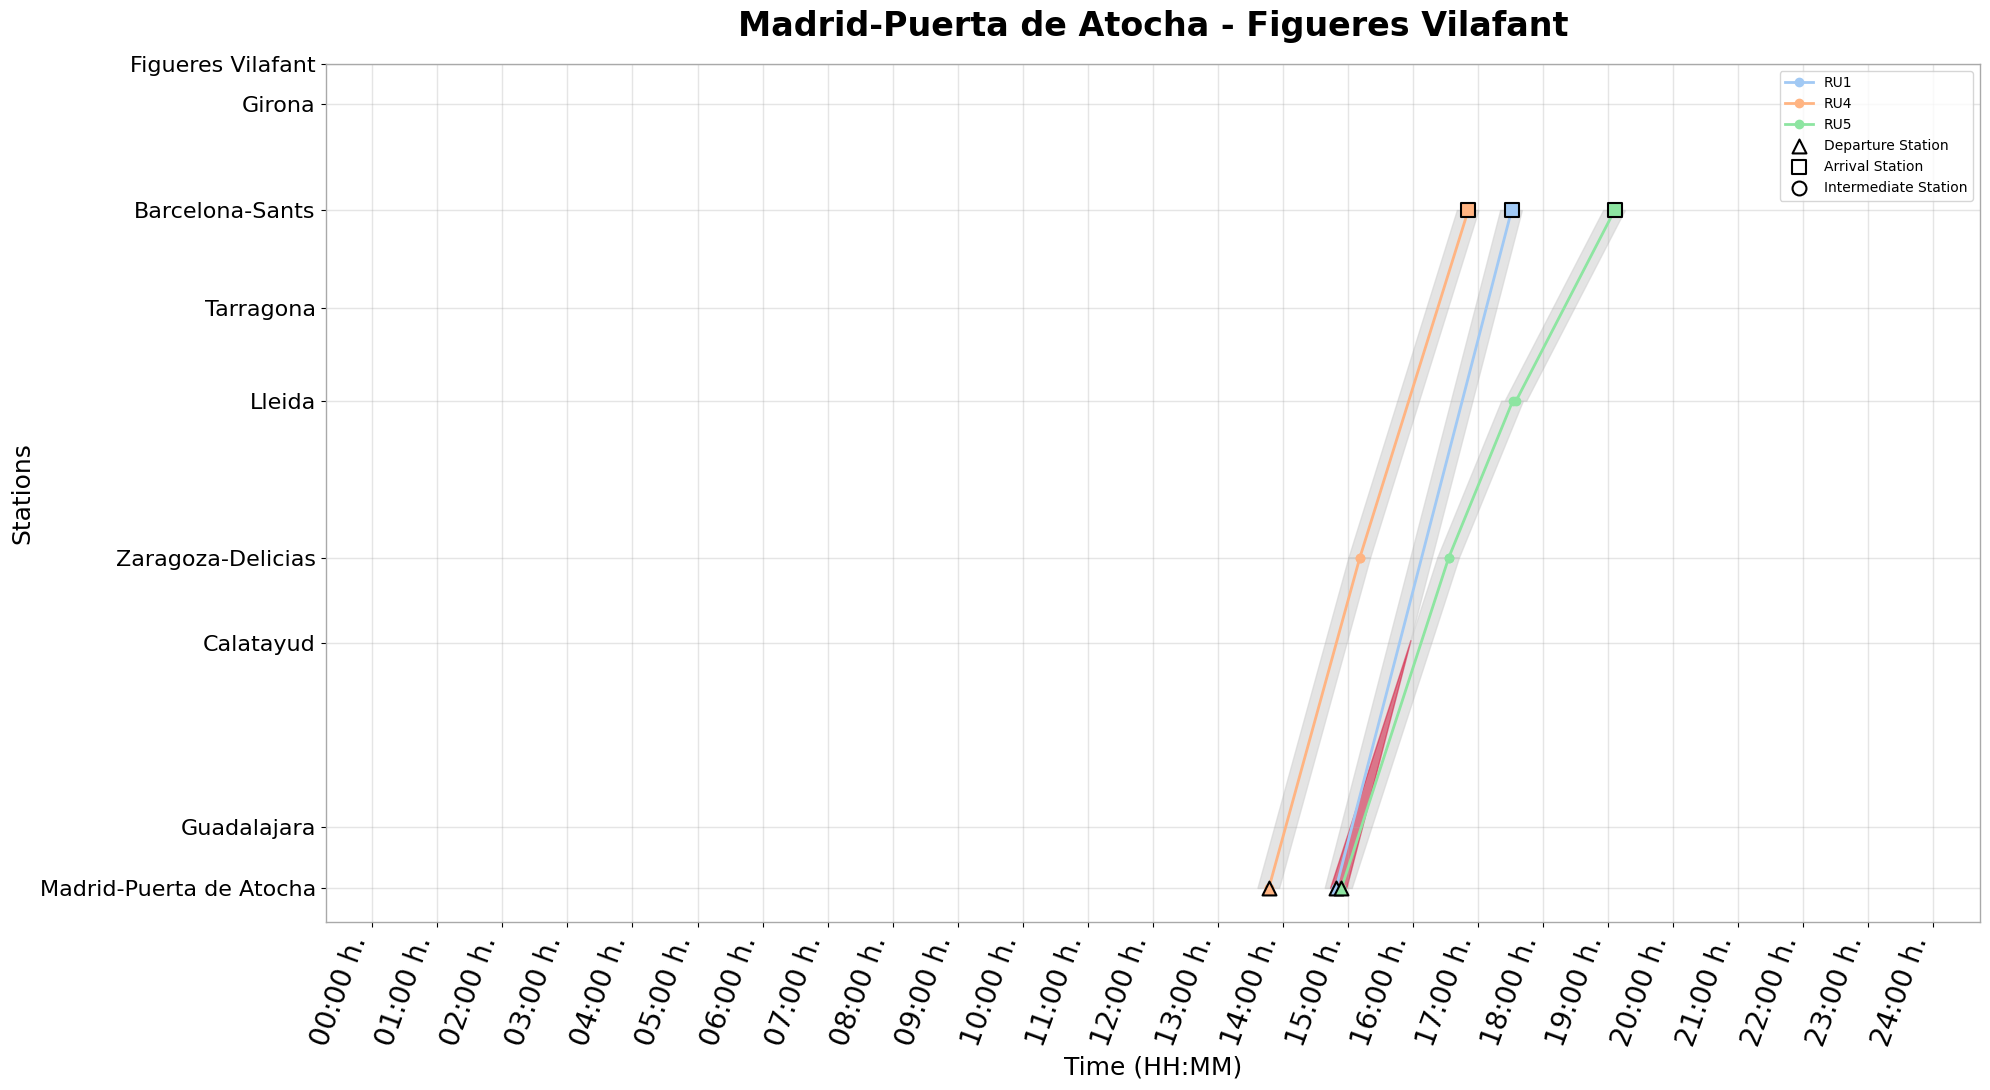

In [25]:
date = datetime.datetime.strptime('2025-06-25', '%Y-%m-%d').date()

updated_supply = Supply.from_yaml(updated_supply_path)

plot_marey_chart(
    supply=updated_supply,
    date=date,
    save_path='../figures/escim2025/'
)